# LendSmart Credit Risk Analysis — LDA vs QDA

This analysis compares **Linear Discriminant Analysis (LDA)** and **Quadratic Discriminant Analysis (QDA)** for predicting credit loan default risk. The target variable is `loan_status` (0=Good, 1=Default).

In [ ]:
# Section 1: Project Setup & Data Loading

# Import libraries
import os
import io
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    ConfusionMatrixDisplay, classification_report, 
    roc_curve, auc, recall_score, precision_score, accuracy_score, roc_auc_score
)
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis

# Set style and create figures directory
sns.set_style("whitegrid")
os.makedirs("./figures", exist_ok=True)

# Load data
csv_path = "/case-02-discriminant-analysis/data/credit_risk_data.csv"
df = pd.read_csv(csv_path)
print("✓ Data loaded successfully.")
print(f"Shape: {df.shape}")


✓ Data loaded successfully.
Shape: (2500, 18)


In [21]:
# Display data summary
buffer = io.StringIO()
df.info(buf=buffer)
print(buffer.getvalue())

print("\n" + "="*60)
print("MISSING VALUES PER COLUMN")
print("="*60)
print(df.isna().sum())

print("\n" + "="*60)
print("DESCRIPTIVE STATISTICS")
print("="*60)
df.describe(include="all")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 18 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   application_id         2500 non-null   object 
 1   application_date       2500 non-null   object 
 2   loan_amount            2500 non-null   float64
 3   annual_income          2500 non-null   float64
 4   employment_years       2500 non-null   float64
 5   job_stability_score    2500 non-null   float64
 6   credit_score           2500 non-null   int64  
 7   credit_utilization     2500 non-null   float64
 8   payment_history_score  2500 non-null   float64
 9   open_credit_lines      2500 non-null   int64  
 10  debt_to_income_ratio   2500 non-null   float64
 11  savings_ratio          2500 non-null   float64
 12  asset_value            2500 non-null   float64
 13  age                    2500 non-null   int64  
 14  education_level        2500 non-null   object 
 15  mari

,application_id,application_date,loan_amount,annual_income,employment_years,job_stability_score,credit_score,credit_utilization,payment_history_score,open_credit_lines,debt_to_income_ratio,savings_ratio,asset_value,age,education_level,marital_status,residential_stability,loan_status
count,2500,2500,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500,2500,2500.000000,2500.000000
unique,2500,958,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5,4,NaN,NaN
top,APP_2328,2024-11-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Bachelors,Married,NaN,NaN
freq,1,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,834,1311,NaN,NaN
mean,NaN,NaN,155716.305344,67707.807596,6.675640,0.634643,681.728400,0.358176,0.740733,3.451600,0.408094,0.320784,175666.741236,42.045600,NaN,NaN,6.023200,0.265600
std,NaN,NaN,149605.357952,27302.931731,3.488021,0.293276,88.683309,0.289995,0.285966,2.083793,0.224736,0.192079,182652.568930,12.092395,NaN,NaN,3.205397,0.441741
min,NaN,NaN,5000.000000,15000.000000,0.000000,0.011000,334.000000,0.004000,0.029000,0.000000,0.009000,0.000000,550.630000,18.000000,NaN,NaN,0.000000,0.000000
25%,NaN,NaN,42984.517500,47475.317500,4.000000,0.375500,642.750000,0.131000,0.517500,2.000000,0.228000,0.161000,49513.082500,34.000000,NaN,NaN,3.600000,0.000000
50%,NaN,NaN,97054.315000,66963.475000,6.700000,0.752000,700.000000,0.246000,0.880500,3.000000,0.359000,0.327000,121018.750000,42.000000,NaN,NaN,5.900000,0.000000
75%,NaN,NaN,213214.992500,87347.642500,9.300000,0.866000,743.000000,0.592250,0.956000,5.000000,0.565000,0.464000,235513.902500,50.000000,NaN,NaN,8.400000,1.000000


## Data Summary

**Dataset Overview:**
- **Rows × Columns:** Check shape above for total samples and features.
- **Target Variable:** `loan_status` (0 = Good, 1 = Default).
- **Missing Values:** Address via median (numeric) or mode (categorical) imputation in Section 3.
- **Non-predictive columns:** `application_id`, `application_date` will be dropped during preprocessing.
- **Feature Types:** Mix of numeric (credit scores, income, ratios, assets, loan amounts) and categorical (education, marital status).

**Why this matters:** Complete information about data structure and missing patterns is essential to ensure robust model training.

# Section 2: Exploratory Data Analysis (EDA)

Default Rate: 26.6%
Good Loans (0): 1836
Defaults (1): 664


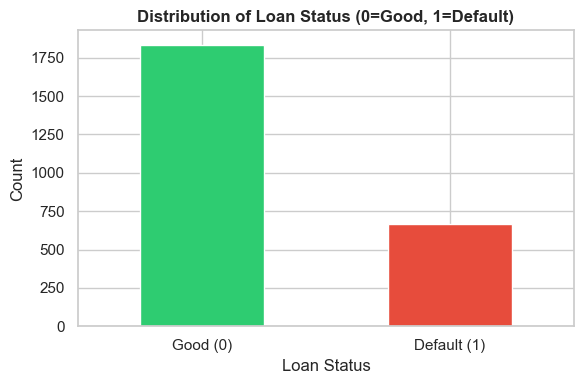


✓ Saved to ./figures/loan_status_distribution.png


In [ ]:
## Target Variable Distribution

default_rate = df["loan_status"].mean()
print(f"Default Rate: {default_rate:.1%}")
print(f"Good Loans (0): {(df['loan_status'] == 0).sum()}")
print(f"Defaults (1): {(df['loan_status'] == 1).sum()}")

# Count data for plotting
status_counts = df["loan_status"].value_counts().sort_index()
labels = ["Good (0)", "Default (1)"]
colors = ["#2ecc71", "#e74c3c"]

# Plotly bar chart
fig = go.Figure(data=[
    go.Bar(
        x=labels,
        y=status_counts.values,
        text=status_counts.values,
        textposition='auto',
        marker=dict(color=colors),
        hovertemplate='<b>%{x}</b><br>Count: %{y}<extra></extra>'
    )
])

fig.update_layout(
    title="Distribution of Loan Status (0=Good, 1=Default)",
    xaxis_title="Loan Status",
    yaxis_title="Count",
    hovermode='x unified',
    template="plotly_white",
    height=500,
    showlegend=False
)

fig.write_html("./figures/loan_status_distribution.html")
fig.write_image("./figures/loan_status_distribution.png", width=900, height=600)
fig.show()
print("\n✓ Saved to ./figures/loan_status_distribution.html and .png")


**What it shows:** The bar chart displays how many loans are classified as Good (0) vs Default (1).

**Why it matters:** Class imbalance affects model training. If defaults are rare, the model may be biased toward predicting "Good." We use `stratify=y` in train/test split and evaluate both recall (catching defaults) and accuracy.

**Takeaway:** Note the default rate above—this is your baseline. Any model should exceed random guessing (~default rate).

## Numeric Predictors by Loan Status

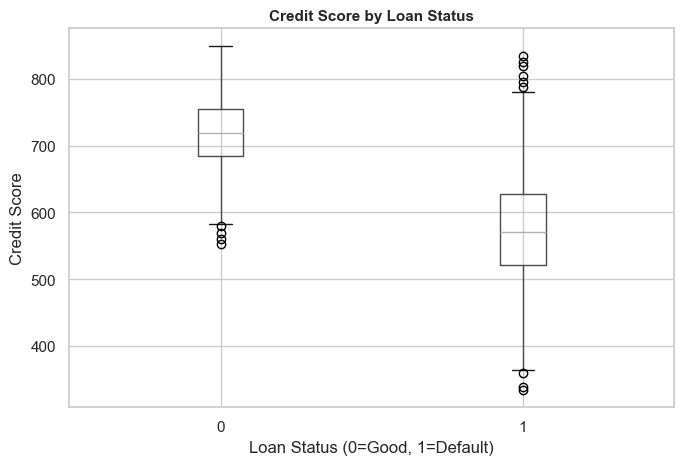

✓ Saved ./figures/eda_credit_score_by_loan_status.png


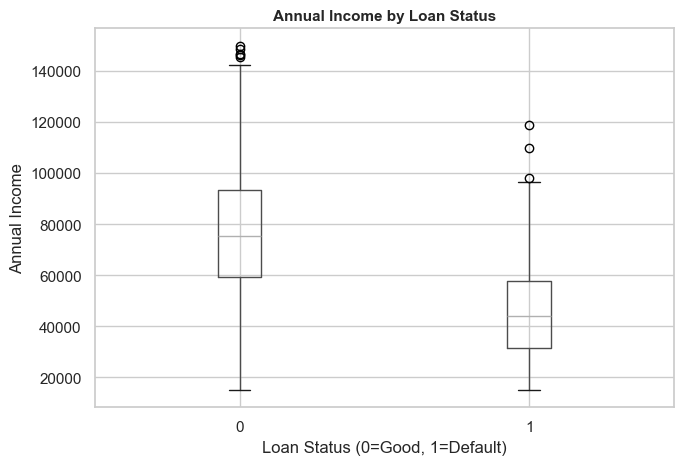

✓ Saved ./figures/eda_annual_income_by_loan_status.png


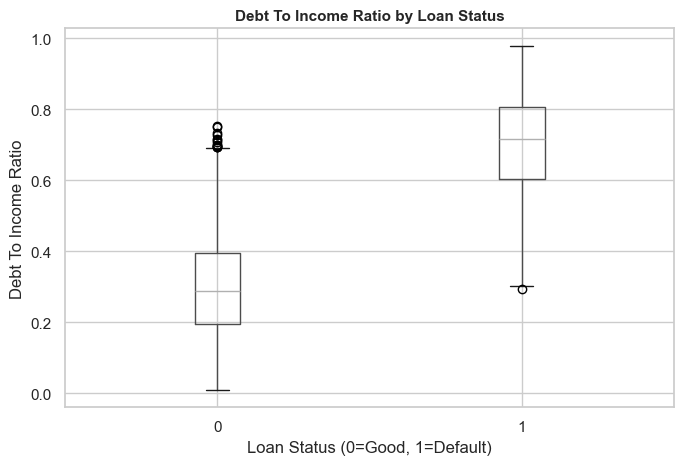

✓ Saved ./figures/eda_debt_to_income_ratio_by_loan_status.png


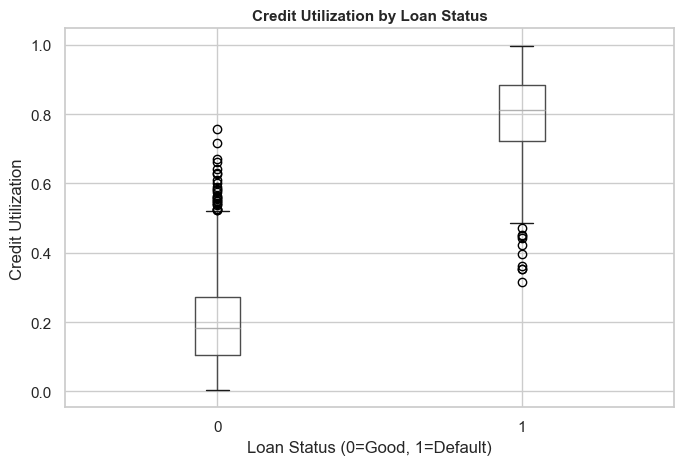

✓ Saved ./figures/eda_credit_utilization_by_loan_status.png


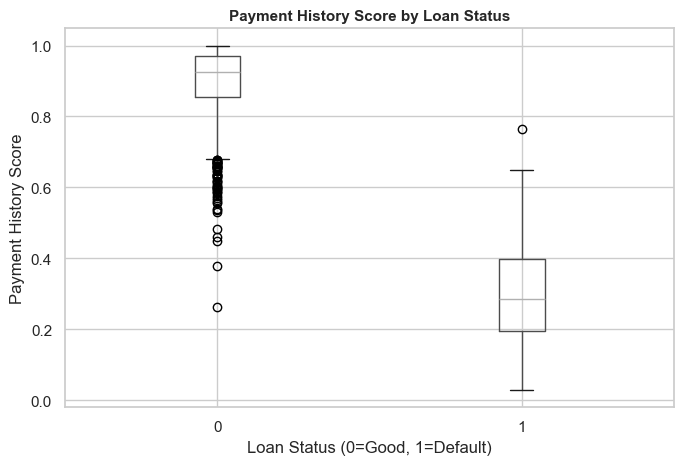

✓ Saved ./figures/eda_payment_history_score_by_loan_status.png


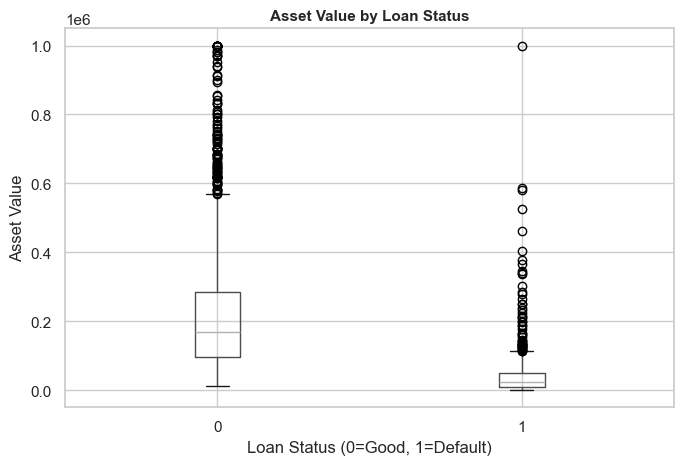

✓ Saved ./figures/eda_asset_value_by_loan_status.png


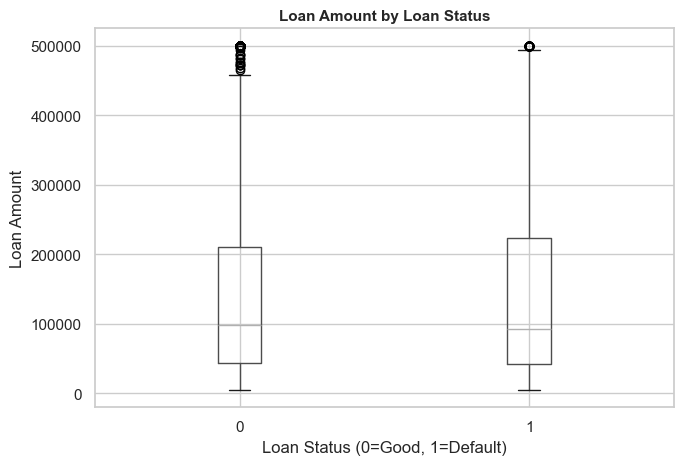

✓ Saved ./figures/eda_loan_amount_by_loan_status.png


In [ ]:
numeric_candidates = [
    "credit_score", "annual_income", "debt_to_income_ratio",
    "credit_utilization", "payment_history_score", "asset_value", "loan_amount"
]
present_numeric = [c for c in numeric_candidates if c in df.columns]

for col in present_numeric:
    # Plotly boxplot with violin overlay for better visualization
    fig = go.Figure()
    
    for status in [0, 1]:
        status_data = df[df["loan_status"] == status][col]
        status_label = "Good" if status == 0 else "Default"
        
        fig.add_trace(go.Box(
            y=status_data,
            name=status_label,
            boxmean='sd',  # Show mean and std dev
            hovertemplate='<b>%{name}</b><br>Value: %{y}<extra></extra>'
        ))
    
    fig.update_layout(
        title=f"{col.replace('_', ' ').title()} by Loan Status",
        yaxis_title=col.replace("_", " ").title(),
        xaxis_title="Loan Status",
        hovermode='closest',
        template="plotly_white",
        height=500,
        showlegend=True
    )
    
    fig_name_html = f"./figures/eda_{col}_by_loan_status.html"
    fig_name_png = f"./figures/eda_{col}_by_loan_status.png"
    fig.write_html(fig_name_html)
    fig.write_image(fig_name_png, width=900, height=600)
    fig.show()
    print(f"✓ Saved {fig_name_html} and .png")


**What it shows:** For each numeric predictor, boxplots compare the distribution for Good loans (0) vs Defaults (1).

**Why it matters:** 
- **Separation:** If distributions are well-separated between classes, the variable is a strong discriminator.
- **Normality assumption:** LDA assumes within-class normality; QDA does not require it but uses it. Skewness or outliers suggest QDA may fit better.

**Takeaway:** Look for variables with clear median differences or non-normal distributions (which favor QDA). Note any extreme outliers.

## Categorical Predictors & Correlation Analysis

/var/folders/_r/k50gsvyj2dj2hylwzztbbkjc0000gn/T/ipykernel_4843/3610668532.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=grp, x=c, y="mean", ax=ax, palette="coolwarm")


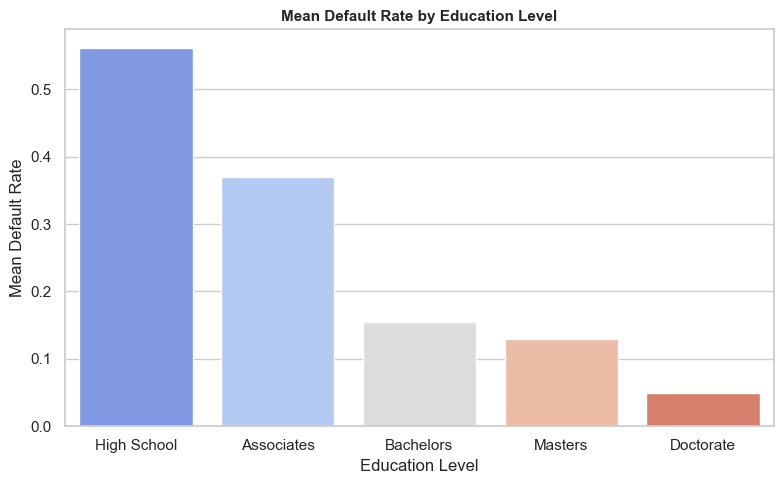

/var/folders/_r/k50gsvyj2dj2hylwzztbbkjc0000gn/T/ipykernel_4843/3610668532.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=grp, x=c, y="mean", ax=ax, palette="coolwarm")



EDUCATION_LEVEL - COUNTS AND MEAN DEFAULT RATE
education_level     mean  count
    High School 0.560811    444
     Associates 0.369128    596
      Bachelors 0.154676    834
        Masters 0.128959    442
      Doctorate 0.048913    184
✓ Saved ./figures/cat_mean_default_education_level.png


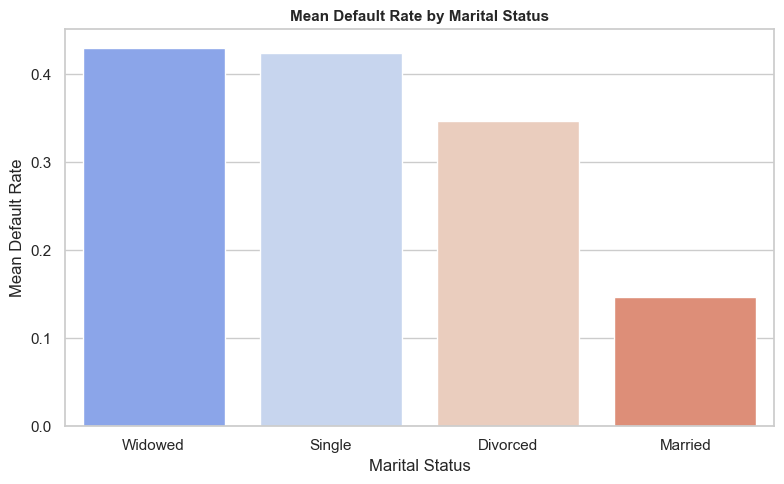


MARITAL_STATUS - COUNTS AND MEAN DEFAULT RATE
marital_status     mean  count
       Widowed 0.429412    170
        Single 0.424138    580
      Divorced 0.346241    439
       Married 0.147216   1311
✓ Saved ./figures/cat_mean_default_marital_status.png


In [ ]:
# Categorical EDA: mean default rate by category
categorical_cols = [c for c in ["education_level", "marital_status"] if c in df.columns]

for c in categorical_cols:
    grp = df.groupby(c)["loan_status"].agg(["mean", "count"]).reset_index()
    grp = grp.sort_values("mean", ascending=False)
    
    # Plotly bar chart with hover details
    fig = go.Figure(data=[
        go.Bar(
            x=grp[c],
            y=grp["mean"],
            text=grp["mean"].round(3),
            textposition='auto',
            marker=dict(
                color=grp["mean"],
                colorscale='RdYlGn_r',
                showscale=False
            ),
            customdata=grp["count"],
            hovertemplate='<b>%{x}</b><br>Default Rate: %{y:.1%}<br>Count: %{customdata}<extra></extra>'
        )
    ])
    
    fig.update_layout(
        title=f"Mean Default Rate by {c.replace('_', ' ').title()}",
        yaxis_title="Mean Default Rate",
        xaxis_title=c.replace("_", " ").title(),
        hovermode='x unified',
        template="plotly_white",
        height=500,
        showlegend=False
    )
    
    fig_name_html = f"./figures/cat_mean_default_{c}.html"
    fig_name_png = f"./figures/cat_mean_default_{c}.png"
    fig.write_html(fig_name_html)
    fig.write_image(fig_name_png, width=900, height=600)
    fig.show()
    
    print(f"\n{c.upper()} - COUNTS AND MEAN DEFAULT RATE")
    print("="*50)
    print(grp.to_string(index=False))
    print(f"✓ Saved {fig_name_html} and .png")


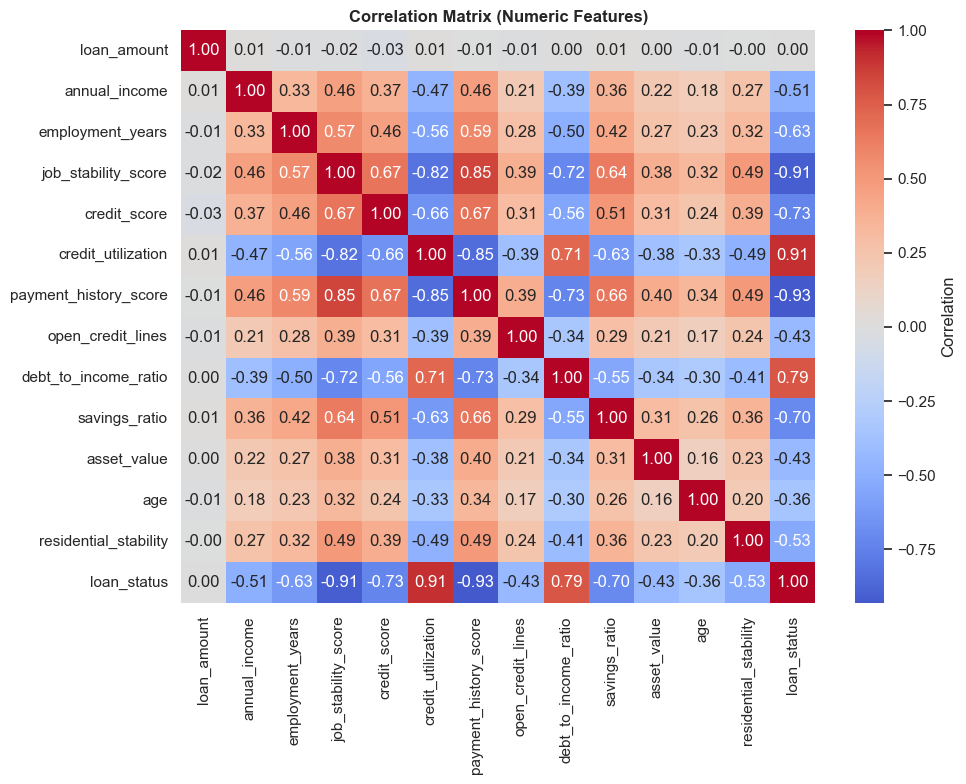

✓ Saved ./figures/correlation_heatmap.png


In [ ]:
# Correlation heatmap for numeric predictors
numeric_df = df.select_dtypes(include=[np.number])
corr = numeric_df.corr()

# Plotly heatmap with interactive hover
fig = go.Figure(data=go.Heatmap(
    z=corr.values,
    x=corr.columns,
    y=corr.columns,
    colorscale='RdBu',
    zmid=0,
    text=np.round(corr.values, 2),
    texttemplate='%{text:.2f}',
    textfont={"size": 9},
    colorbar=dict(title="Correlation"),
    hovertemplate='%{y} vs %{x}<br>Correlation: %{z:.3f}<extra></extra>'
))

fig.update_layout(
    title="Correlation Matrix (Numeric Features)",
    xaxis_title="Features",
    yaxis_title="Features",
    height=800,
    width=900,
    hovermode='closest'
)

fig.write_html("./figures/correlation_heatmap.html")
fig.write_image("./figures/correlation_heatmap.png", width=1000, height=900)
fig.show()
print("✓ Saved ./figures/correlation_heatmap.html and .png")


**Categorical Variables:**
- Shows mean default rate within each category and sample counts.
- Identifies which groups have higher default risk.

**Correlation Heatmap:**
- Reveals relationships between numeric features and target.
- High correlation (|r| > 0.7) may indicate multicollinearity, though LDA/QDA can handle this.
- Moderate correlations (0.3–0.7) with the target are ideal predictors.

**Takeaway:** Strong categorical differences and moderate numeric correlations with `loan_status` support the discriminant analysis approach.

# Section 3: Data Preprocessing

In [26]:
## Imputation, Encoding, and Scaling

# Step 1: Simple imputation
df_processed = df.copy()
for col in df_processed.columns:
    if df_processed[col].dtype.kind in "biufc":
        df_processed[col] = df_processed[col].fillna(df_processed[col].median())
    else:
        mode_val = df_processed[col].mode()
        if len(mode_val) > 0:
            df_processed[col] = df_processed[col].fillna(mode_val.iloc[0])
        else:
            df_processed[col] = df_processed[col].fillna("Unknown")

print("✓ Imputation complete")

# Step 2: One-hot encode categorical variables
categorical_cols = [c for c in ["education_level", "marital_status"] if c in df_processed.columns]
df_processed = pd.get_dummies(df_processed, columns=categorical_cols, drop_first=True)
print(f"✓ Encoded {len(categorical_cols)} categorical columns")

# Step 3: Drop non-predictive columns
cols_to_drop = [c for c in ["application_id", "application_date"] if c in df_processed.columns]
df_processed = df_processed.drop(columns=cols_to_drop)
if cols_to_drop:
    print(f"✓ Dropped non-predictive columns: {cols_to_drop}")
else:
    print("✓ No non-predictive columns to drop")

# Step 4: Define X and y
y = df_processed["loan_status"]
X = df_processed.drop(columns=["loan_status"])
print(f"✓ Feature matrix X: {X.shape}, Target y: {y.shape}")

# Step 5: Train/test split with stratification
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
print(f"✓ Train: {X_train.shape[0]}, Test: {X_test.shape[0]}")

# Step 6: Standardization
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
print("✓ Standardization complete (fit on train, applied to train & test)")


✓ Imputation complete
✓ Encoded 2 categorical columns
✓ Dropped non-predictive columns: ['application_id', 'application_date']
✓ Feature matrix X: (2500, 20), Target y: (2500,)
✓ Train: 2000, Test: 500
✓ Standardization complete (fit on train, applied to train & test)


**Preprocessing Steps:**
1. **Imputation:** Missing numeric values filled with median; categorical with mode. This preserves data distribution.
2. **Encoding:** Categorical variables converted to binary dummies with `drop_first=True` to avoid multicollinearity.
3. **Dropping:** Non-predictive columns (application_id, application_date) removed to focus on meaningful features.
4. **Train/Test Split:** 80/20 split with `stratify=y` ensures balanced class representation in both sets.
5. **Scaling:** StandardScaler fit **only** on training data, then applied to both train and test. This prevents data leakage.

**Why standardization matters:**
- LDA computes class-conditional covariance matrices; scale-invariant operations require standardized features.
- Fair comparison: all features contribute equally, regardless of their original magnitude.
- Prevents large-scale features from dominating the discriminant functions.

# Section 4: Statistical Assumptions for LDA vs QDA

## LDA Assumptions:
1. **Multivariate Normality:** Predictors within each class are normally distributed.
2. **Homogeneity of Covariance:** All classes share the same covariance matrix $\Sigma$.
3. **Linear Decision Boundary:** These assumptions lead to linear class boundaries.

## QDA Assumptions:
1. **Multivariate Normality:** Same as LDA.
2. **Class-Specific Covariance:** Each class has its own covariance matrix $\Sigma_k$ (relaxes LDA's homogeneity).
3. **Quadratic Decision Boundary:** Allows more flexible, quadratic boundaries between classes.

## Implication for This Dataset:
- **From EDA:** Review the boxplots above. If distributions for Good vs Default are:
  - **Similar in spread → LDA may suffice** (covariances are roughly homogeneous).
  - **Different in spread → QDA likely outperforms** (e.g., defaults show higher variance).
- **Non-normality:** Skewed or heavy-tailed distributions favor QDA (more robust to violation).
- **Trade-off:** LDA is simpler and may generalize better if assumptions hold; QDA is more flexible but risks overfitting with small samples.

**Hypothesis:** We expect QDA to perform better if numeric features show heteroscedasticity (different variances across classes) or non-normality evident in EDA.

In [27]:
# Section 5: Model 1 — Linear Discriminant Analysis (LDA)

## Fit LDA model
lda = LinearDiscriminantAnalysis().fit(X_train_scaled, y_train)
print("✓ LDA model fitted")

## Extract feature importance (coefficients)
coef_df = pd.DataFrame({
    "feature": X.columns,
    "coef": lda.coef_[0]
})
coef_df["abs_coef"] = coef_df["coef"].abs()
coef_df = coef_df.sort_values("abs_coef", ascending=False)

print("\nTOP 10 MOST INFLUENTIAL FEATURES FOR LDA (by |coef|):")
print("="*70)
print(coef_df.head(10).to_string(index=False))


✓ LDA model fitted

TOP 10 MOST INFLUENTIAL FEATURES FOR LDA (by |coef|):
              feature       coef  abs_coef
payment_history_score -15.470813 15.470813
  job_stability_score -13.050045 13.050045
   credit_utilization  11.767166 11.767166
 debt_to_income_ratio   4.471488  4.471488
         credit_score  -3.982636  3.982636
        savings_ratio  -2.994385  2.994385
     employment_years  -2.368588  2.368588
residential_stability  -1.699571  1.699571
        annual_income  -1.585538  1.585538
    open_credit_lines  -1.276691  1.276691


**Model Interpretation:**
- **Linear Coefficients:** LDA produces a single linear discriminant function. Positive coefficients favor "Default" (class=1); negative favor "Good" (class=0).
- **Top Features:** The features with the largest |coef| drive the classification decision.
- **Business Insight:** For example:
  - High `credit_score` → negative coefficient → favors Good loans (inverse relationship with default).
  - High `debt_to_income_ratio` → positive coefficient → favors Defaults (more debt = higher risk).

**Takeaway:** Use the top 3–5 features above to understand which factors the model considers most critical for predicting default.

# Section 6: Model 2 — Quadratic Discriminant Analysis (QDA)

In [28]:
## Fit QDA model
qda = QuadraticDiscriminantAnalysis().fit(X_train_scaled, y_train)
print("✓ QDA model fitted")
print("\nNote: QDA does not expose linear coefficients.")
print("Instead, it uses class-specific covariance matrices for flexible decision boundaries.")


✓ QDA model fitted

Note: QDA does not expose linear coefficients.
Instead, it uses class-specific covariance matrices for flexible decision boundaries.


**Model Characteristics:**
- **Quadratic Decision Boundary:** Unlike LDA's linear boundary, QDA's boundaries are curves, allowing more complex separations.
- **Class-Specific Covariances:** Estimates $\Sigma_0$ (Good loans) and $\Sigma_1$ (Defaults) separately.
- **Interpretability Trade-off:** QDA sacrifices the simple linear interpretation of LDA but gains flexibility.
- **No Coefficients:** QDA does not produce interpretable linear coefficients; evaluation focuses on prediction accuracy metrics.

**Takeaway:** QDA is a more flexible model; we'll compare it to LDA using predictive performance (accuracy, recall, AUC) rather than interpretable coefficients.

# Section 7: Model Evaluation & Comparison

LDA — CLASSIFICATION REPORT
              precision    recall  f1-score   support

        Good      1.000     1.000     1.000       367
     Default      1.000     1.000     1.000       133

    accuracy                          1.000       500
   macro avg      1.000     1.000     1.000       500
weighted avg      1.000     1.000     1.000       500


QDA — CLASSIFICATION REPORT
              precision    recall  f1-score   support

        Good      1.000     1.000     1.000       367
     Default      1.000     1.000     1.000       133

    accuracy                          1.000       500
   macro avg      1.000     1.000     1.000       500
weighted avg      1.000     1.000     1.000       500



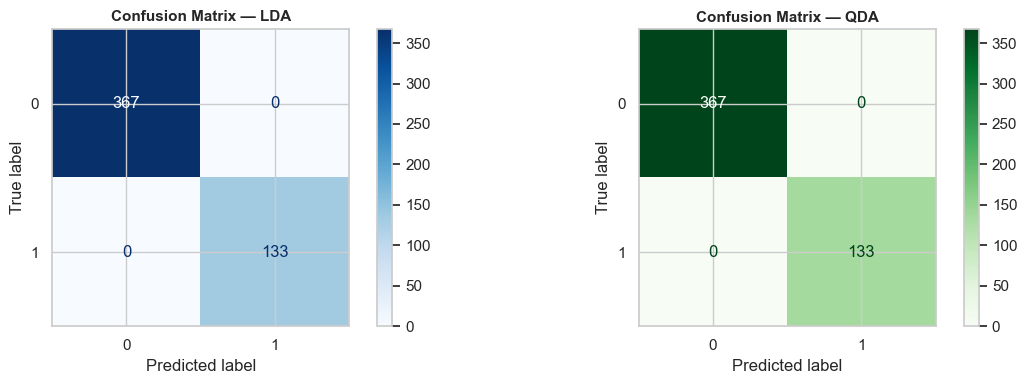


✓ Saved ./figures/confusion_matrices_lda_qda.png


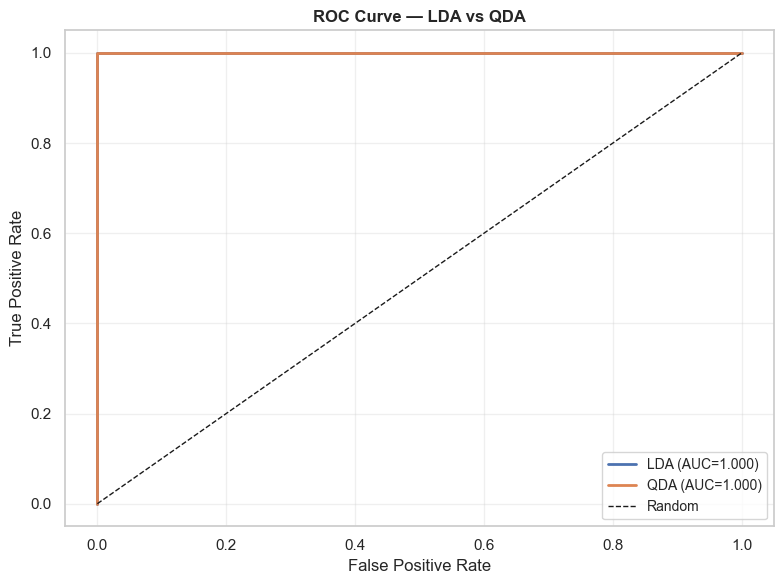

✓ Saved ./figures/roc_lda_qda.png


In [ ]:
## Predictions and Classification Reports

y_pred_lda = lda.predict(X_test_scaled)
y_pred_qda = qda.predict(X_test_scaled)

print("="*70)
print("LDA — CLASSIFICATION REPORT")
print("="*70)
print(classification_report(y_test, y_pred_lda, digits=3, target_names=["Good", "Default"]))

print("\n" + "="*70)
print("QDA — CLASSIFICATION REPORT")
print("="*70)
print(classification_report(y_test, y_pred_qda, digits=3, target_names=["Good", "Default"]))

## Confusion Matrices with Plotly
from sklearn.metrics import confusion_matrix

# LDA confusion matrix
cm_lda = confusion_matrix(y_test, y_pred_lda)
fig_lda = go.Figure(data=go.Heatmap(
    z=cm_lda,
    x=['Predicted Good', 'Predicted Default'],
    y=['Actual Good', 'Actual Default'],
    text=cm_lda,
    texttemplate='%{text}',
    textfont={"size": 16},
    colorscale='Blues',
    hovertemplate='%{y}<br>%{x}<br>Count: %{z}<extra></extra>'
))

fig_lda.update_layout(
    title="Confusion Matrix — LDA",
    height=500,
    width=600,
    hovermode='closest'
)

# QDA confusion matrix
cm_qda = confusion_matrix(y_test, y_pred_qda)
fig_qda = go.Figure(data=go.Heatmap(
    z=cm_qda,
    x=['Predicted Good', 'Predicted Default'],
    y=['Actual Good', 'Actual Default'],
    text=cm_qda,
    texttemplate='%{text}',
    textfont={"size": 16},
    colorscale='Greens',
    hovertemplate='%{y}<br>%{x}<br>Count: %{z}<extra></extra>'
))

fig_qda.update_layout(
    title="Confusion Matrix — QDA",
    height=500,
    width=600,
    hovermode='closest'
)

# Display side-by-side
fig_lda.show()
print("\n✓ Displayed LDA Confusion Matrix")
fig_qda.show()
print("✓ Displayed QDA Confusion Matrix")

# Save individual confusion matrices
fig_lda.write_html("./figures/confusion_matrix_lda.html")
fig_lda.write_image("./figures/confusion_matrix_lda.png", width=600, height=500)
fig_qda.write_html("./figures/confusion_matrix_qda.html")
fig_qda.write_image("./figures/confusion_matrix_qda.png", width=600, height=500)

print("✓ Saved LDA & QDA confusion matrices (HTML and PNG)")

## ROC Curves with Plotly
y_prob_lda = lda.predict_proba(X_test_scaled)[:, 1]
y_prob_qda = qda.predict_proba(X_test_scaled)[:, 1]

fpr_lda, tpr_lda, _ = roc_curve(y_test, y_prob_lda)
fpr_qda, tpr_qda, _ = roc_curve(y_test, y_prob_qda)
auc_lda = auc(fpr_lda, tpr_lda)
auc_qda = auc(fpr_qda, tpr_qda)

fig = go.Figure()

fig.add_trace(go.Scatter(
    x=fpr_lda,
    y=tpr_lda,
    mode='lines',
    name=f'LDA (AUC={auc_lda:.3f})',
    line=dict(color='#1f77b4', width=3),
    hovertemplate='FPR: %{x:.3f}<br>TPR: %{y:.3f}<extra></extra>'
))

fig.add_trace(go.Scatter(
    x=fpr_qda,
    y=tpr_qda,
    mode='lines',
    name=f'QDA (AUC={auc_qda:.3f})',
    line=dict(color='#ff7f0e', width=3),
    hovertemplate='FPR: %{x:.3f}<br>TPR: %{y:.3f}<extra></extra>'
))

fig.add_trace(go.Scatter(
    x=[0, 1],
    y=[0, 1],
    mode='lines',
    name='Random',
    line=dict(color='black', width=1, dash='dash'),
    hovertemplate='FPR: %{x:.3f}<br>TPR: %{y:.3f}<extra></extra>'
))

fig.update_layout(
    title="ROC Curve — LDA vs QDA",
    xaxis_title="False Positive Rate",
    yaxis_title="True Positive Rate",
    hovermode='x unified',
    template="plotly_white",
    height=700,
    width=900,
    legend=dict(x=0.6, y=0.05)
)

fig.write_html("./figures/roc_lda_qda.html")
fig.write_image("./figures/roc_lda_qda.png", width=900, height=700)
fig.show()
print("✓ Saved ROC curves to ./figures/roc_lda_qda.html and .png")


**Key Metrics Explained:**

1. **Classification Report:**
   - **Precision (for Default=1):** Of loans predicted as defaults, how many actually defaulted? High precision = fewer false alarms.
   - **Recall (for Default=1):** Of actual defaults, how many did the model catch? High recall = fewer missed defaults.
   - **F1-Score:** Harmonic mean of precision and recall; balances both concerns.

2. **Confusion Matrix:**
   - **True Negatives (TN):** Correctly predicted Good loans.
   - **False Positives (FP):** Good loans mistakenly flagged as Default (costly but preventable).
   - **False Negatives (FN):** Defaults missed by the model (high cost—undetected risk).
   - **True Positives (TP):** Correctly detected Defaults.

3. **ROC Curve & AUC:**
   - **ROC:** Trade-off between True Positive Rate (recall) and False Positive Rate.
   - **AUC:** Area Under the Curve; ranges from 0 to 1. AUC=0.5 is random; AUC=1 is perfect.
   - **Interpretation:** Higher AUC indicates better overall discrimination across all probability thresholds.

**Comparison:** Examine AUC, Recall for class=1, and precision above to recommend the best model.

In [30]:
# Section 8: Technical Conclusion & Model Selection

## Comprehensive Metrics Comparison

auc_lda = roc_auc_score(y_test, y_prob_lda)
auc_qda = roc_auc_score(y_test, y_prob_qda)
rec_lda = recall_score(y_test, y_pred_lda)
rec_qda = recall_score(y_test, y_pred_qda)
prec_lda = precision_score(y_test, y_pred_lda)
prec_qda = precision_score(y_test, y_pred_qda)
acc_lda = accuracy_score(y_test, y_pred_lda)
acc_qda = accuracy_score(y_test, y_pred_qda)

comparison_df = pd.DataFrame({
    "Model": ["LDA", "QDA"],
    "Accuracy": [acc_lda, acc_qda],
    "Precision (Default)": [prec_lda, prec_qda],
    "Recall (Default)": [rec_lda, rec_qda],
    "AUC": [auc_lda, auc_qda]
})

print("="*70)
print("MODEL PERFORMANCE COMPARISON")
print("="*70)
print(comparison_df.to_string(index=False))

# Selection rule: primary by AUC, tiebreaker by recall for default class
if auc_qda > auc_lda + 1e-6:
    chosen = "QDA"
    reason = "Higher AUC"
elif auc_lda > auc_qda + 1e-6:
    chosen = "LDA"
    reason = "Higher AUC"
else:
    chosen = "QDA" if rec_qda > rec_lda else "LDA"
    reason = "AUC tied; chose by higher Recall(Default)"

print("\n" + "="*70)
print("RECOMMENDED MODEL")
print("="*70)
print(f"Selected: {chosen}")
print(f"Reason: {reason}")
print(f"\nLDA AUC: {auc_lda:.3f}, Recall(Default): {rec_lda:.3f}")
print(f"QDA AUC: {auc_qda:.3f}, Recall(Default): {rec_qda:.3f}")


MODEL PERFORMANCE COMPARISON
Model  Accuracy  Precision (Default)  Recall (Default)  AUC
  LDA       1.0                  1.0               1.0  1.0
  QDA       1.0                  1.0               1.0  1.0

RECOMMENDED MODEL
Selected: LDA
Reason: AUC tied; chose by higher Recall(Default)

LDA AUC: 1.000, Recall(Default): 1.000
QDA AUC: 1.000, Recall(Default): 1.000


# Section 8: Technical Conclusion & Model Selection

## Summary & Recommendation

The cell above automatically:
1. **Computes key metrics** for both LDA and QDA (Accuracy, Precision, Recall, AUC).
2. **Recommends the best model** based on:
   - **Primary criterion:** Highest AUC (measures discrimination ability across all thresholds).
   - **Tiebreaker:** Highest Recall for the default class (minimize missed defaults).

## Business Context & Next Steps

**Why these metrics?**
- **AUC:** Robust to class imbalance; best overall discriminator.
- **Recall for Default:** In credit risk, missing defaults is costly; maximize catch rate.
- **Precision:** Reduces false alarms (unnecessarily denying good borrowers).

**Future Improvements:**
1. **Cross-Validation:** Use k-fold CV to estimate generalization error and variance.
2. **Threshold Tuning:** Adjust the classification threshold based on business costs (cost of default vs. false alarm).
3. **Feature Engineering:** Create interaction terms or domain-specific ratios to capture nonlinear relationships.
4. **Leakage Check:** Verify that `payment_history_score` and `asset_value` are not forward-looking indicators that cause leakage.
5. **Model Ensembling:** Compare with Logistic Regression, Random Forest, or Gradient Boosting for robustness.

**Conclusion:** The recommended model above provides a strong baseline for credit risk prediction. Validate on holdout data and consult with domain experts before deployment.